In [ ]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
############### upload data
# Mount Google drive to load data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

path ='/content/drive/MyDrive/ece367/ECE324 project/dataProcessing/processed_data_aug/test.csv'

text_data = pd.read_csv(path, sep=',')
print(text_data)
print(text_data["toxic"].value_counts())

                    id  ... identity_hate
0     2a2805dc384e9b60  ...             1
1     cc738bd89c1a1dc5  ...             0
2     218bdcbae72b1def  ...             0
3     d3bf5e38c76a5c0d  ...             0
4     586a2aefd01e5316  ...             0
...                ...  ...           ...
2534  2489283ccba99a24  ...             0
2535  5e70615ce678ee05  ...             0
2536  5e0584dcf993c0aa  ...             0
2537  35243af9766437b5  ...             1
2538  71c6a5551bc1b17e  ...             0

[2539 rows x 8 columns]
1    2063
0     476
Name: toxic, dtype: int64


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext import data
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import argparse
import os
import datetime, time

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_LSTM(nn.Module):
    def __init__(self, embedding_dim, vocab, hidden_dim=100):
        super(CNN_LSTM, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(vocab.vectors)
        self.hidden_dim = hidden_dim

        self.conv1 = nn.Conv2d(1, 100,kernel_size=(2,embedding_dim)) #in_channels, out_chanels, kernel_size
        
        
        self.lstm1 = nn.LSTM(embedding_dim,hidden_dim)
        target_size = 1
        self.fc1 = nn.Linear(hidden_dim, target_size)

    def forward(self, x, lengths):
    #   embeds = self.word_embeddings(sentence)
    #     lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
    #     tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    #     tag_scores = F.log_softmax(tag_space, dim=1)
    #     return tag_scores
        
        x = self.embedding(x)
        # print('x.shape',x.shape)

        x = x.unsqueeze(0)
        # print('x = x.unsqueeze(0)',x.shape)
        x = x.transpose(1,2) # swaps 2nd and 3rd dimension
        # print('x = x.transpose(1,2)',x.shape)
        x = x.transpose(0,1) # swaps 1st and 2nd dimension, now it has the correct input (n_samples,channels, height, width)
        # print('x = x.transpose(0,1)',x.shape)
        x1 = F.relu(self.conv1(x)) 
        # print('x1 = F.relu(self.conv1(x))',x1.shape)
        
        x1 = x1.squeeze(3)
        # print('x1 = x1.squeeze(3)',x1.shape)
        pool1 = nn.MaxPool1d(x1.size(2), 1) #maxpool
        
        x = pool1(x1)
        # print('pool1 = nn.MaxPool1d(x1.size(2), 1)',x.shape)
        x = x.squeeze(2)
        x = x.unsqueeze(0)
        # print('x = x.squeeze(2)',x.shape)


        #  pack the word embeddings in the batch together and 
        # run the RNN on this object
        # x = pack_padded_sequence(x,lengths) 
        # print('x.shape',x.shape)
        x,(h,c) = self.lstm1(x)
        # print('x.shape',x.shape)
        # print('h.shape',h.shape)
        # print('len(h)',len(h))
        # print('(x.view(len(lengths),-1)).shape',(x.view(len(lengths),-1)).shape)
        h_result = self.fc1(h.squeeze(0))
        # h_result = F.log_softmax(tag_space, dim=1) --> change to this with multiple cat
        h_result = torch.sigmoid(h_result)
        

        return h_result.squeeze(1)

In [ ]:
x = torch.ones(2, 3)
# y = torch.ones(5, 3)
y = torch.from_numpy(np.array([[1,0,0],[0,1,1]])).float()
print(x)
print(y)
temp = (x == y)
# print(temp)
sum_all = 0
comb_correct = 0
avg_acc = 0
for i in temp:
  print(i)
  if torch.equal(i, torch.BoolTensor([True, True,True])):
        comb_correct += 1
  sum_all = torch.count_nonzero(i)
  acc = sum_all/len(i)
  avg_acc += acc
  print(avg_acc)
print(sum_all)
print(comb_correct)
print(avg_acc/3)

tensor([[1., 1., 1.],
        [1., 1., 1.]])
tensor([[1., 0., 0.],
        [0., 1., 1.]])
tensor([ True, False, False])
tensor(0.3333)
tensor([False,  True,  True])
tensor(1.)
tensor(2)
0
tensor(0.3333)


## train

epoch---------------------------------------------- 0
-----------------severe_toxic_correct 17060
-----------------severe_toxic_total 20300
-----------------severe_toxic_correct 0.8403940886699507
cat ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
[1] toxic_train loss: 0.507, toxic_train acc: 0.806, toxic_validation loss: 0.618, toxic_validation acc: 0.695,         toxic_testing loss: 0.586, toxic_testing acc: 0.729 
[1] severe_toxic_train loss: 0.707, severe_toxic_train acc: 0.840, severe_toxic_validation loss: 0.695, severe_toxic_validation acc: 0.781,        severe_toxic_testing loss: 0.696, severe_toxic_testing acc: 0.673 
[1] obscene_train loss: 0.632, obscene_train acc: 0.691, obscene_validation loss: 0.639, obscene_validation acc: 0.790,        obscene_testing loss: 0.557, obscene_testing acc: 0.832 
[1] threat_train loss: 0.903, threat_train acc: 0.873, threat_validation loss: 0.907, threat_validation acc: 0.876,        threat_testing loss: 0.880, thr

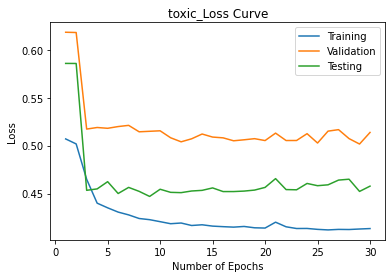

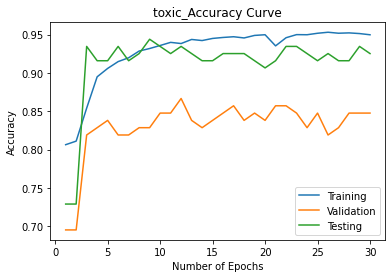

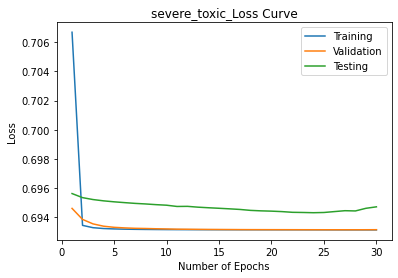

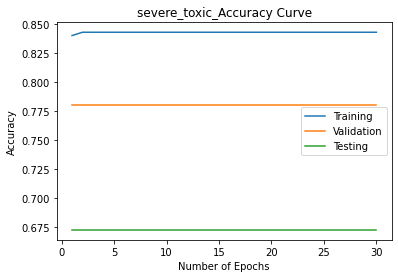

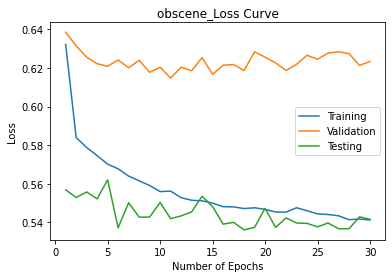

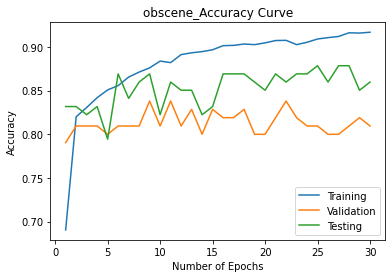

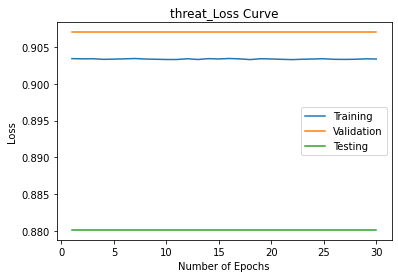

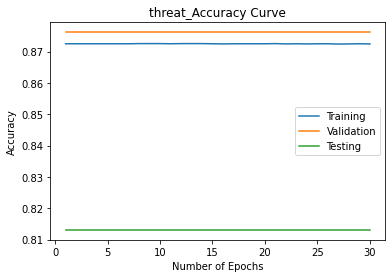

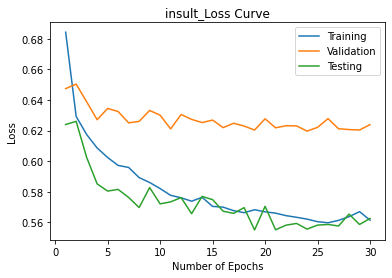

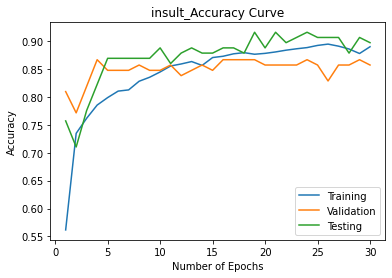

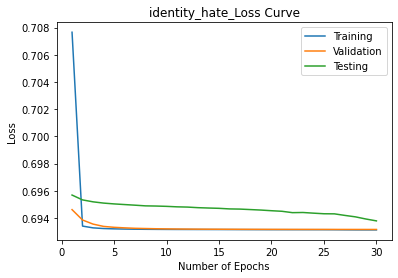

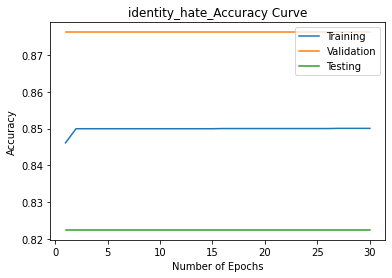

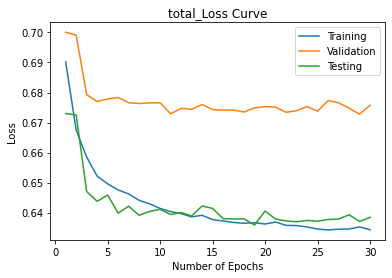

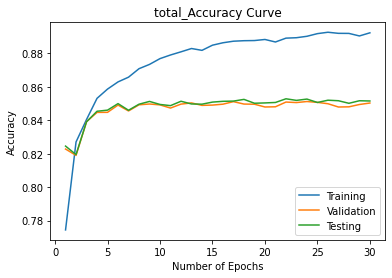

In [ ]:
trainRNN_R(seed = 0, batch_size = 128, learning_rate = 0.001, epochs = 30, model = CNN_LSTM, emb_dim = 100, rnn_hidden_dim = 100, num_filt = 50)

In [ ]:
def trainRNN_R(seed = 0, batch_size = 64, learning_rate = 0.001, epochs = 25, model = CNN_LSTM, emb_dim = 100, rnn_hidden_dim = 100, num_filt = 50):
    
  torch.manual_seed(seed)

  COMMENT_TEXT    = data.Field(sequential=True,lower=True, tokenize='spacy', include_lengths=True)
  TOXIC           = data.Field(sequential=False, use_vocab=False)
  SEVERE_TOXIC    = data.Field(sequential=False, use_vocab=False)
  OBSCENE         = data.Field(sequential=False, use_vocab=False)
  THREAT          = data.Field(sequential=False, use_vocab=False)
  INSULT          = data.Field(sequential=False, use_vocab=False)
  IDENTITY_HATE   = data.Field(sequential=False, use_vocab=False)

  train_data, val_data, test_data = data.TabularDataset.splits(
          # path='/content/drive/MyDrive/ece367/ECE324 project/dataProcessing/new_processed_data/', train='train.csv',
          # validation='valid.csv', test='test.csv', format='csv',
          # skip_header=True, fields=[('id', None), ('text', COMMENT_TEXT), ('toxic', TOXIC), ('severe_toxic', SEVERE_TOXIC), ('obscene', OBSCENE), ('threat', THREAT), ('insult', INSULT), ('identity_hate', IDENTITY_HATE)])
          
          
          path='/content/drive/MyDrive/ece367/ECE324 project/dataProcessing/processed_data_aug/', train='train.csv',
          validation='valid.csv', test='test.csv', format='csv',
          skip_header=True, fields=[('id', None), ('text', COMMENT_TEXT), ('toxic', TOXIC), ('severe_toxic', SEVERE_TOXIC), ('obscene', OBSCENE), ('threat', THREAT), ('insult', INSULT), ('identity_hate', IDENTITY_HATE)])
          
          # path='/content/drive/MyDrive/ece367/ECE324 project/dataProcessing/multi_loose_large_data/', train='train.csv',
          # validation='valid.csv', test='test.csv', format='csv',
          # skip_header=True, fields=[('id', None), ('text', COMMENT_TEXT), ('toxic', TOXIC), ('severe_toxic', SEVERE_TOXIC), ('obscene', OBSCENE), ('threat', THREAT), ('insult', INSULT), ('identity_hate', IDENTITY_HATE)])
          
  train_iter, val_iter, test_iter = data.BucketIterator.splits(
      (train_data, val_data, test_data), batch_sizes=(batch_size, batch_size,batch_size),
      sort_key=lambda x: len(x.text), device=None, sort_within_batch=True, repeat=False)

  COMMENT_TEXT.build_vocab(train_data, val_data, test_data)

  COMMENT_TEXT.vocab.load_vectors(torchtext.vocab.GloVe(name='6B', dim=100))
  vocab = COMMENT_TEXT.vocab

  def save_vocab(vocab):
    import pickle
    output = open('vocab.pkl', 'wb')
    pickle.dump(vocab, output)
    output.close()
  save_vocab(vocab)

  cat = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

  train_classifier(cat,vocab,train_iter, val_iter, test_iter,seed, learning_rate, epochs, model, emb_dim, rnn_hidden_dim, num_filt) 
  
  

In [ ]:
def batch_label(batch, cat):
    if cat == 'toxic':
      return batch.toxic.float() 
    elif cat == 'severe_toxic':
      return batch.severe_toxic.float() 
    elif cat == 'obscene':
      return batch.obscene.float() 
    elif cat == 'threat':
      return batch.threat.float() 
    elif cat == 'insult':
      return batch.insult.float() 
    elif cat == 'identity_hate':
      return batch.identity_hate.float() 
    else:
      print("ERROR: wrong category name")

def get_binary_accuracy(model,batch_input,batch_input_length,learning_rate,labels):  
    valCorrect = 0
    valRunningLoss = 0.0
    valNumberOfBatches = 0
    valTotal = 0
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    outputs = model(batch_input, batch_input_length)

    loss = criterion(outputs, labels)
    valRunningLoss += loss.item()
    outputs = (outputs>0.5).float()
    
    valCorrect += (outputs == labels).sum().item()
    valTotal += labels.size(0)
    # print('valTotal += labels.size(0)',valTotal)
    valNumberOfBatches += 1
    valRunningLoss = valRunningLoss/valNumberOfBatches
    valCorrect = valCorrect/valTotal

    return valRunningLoss,valCorrect,outputs,valTotal


def evaluate_combined_correct(toxic_outputs,toxic_labels,severe_toxic_outputs,severe_toxic_labels,\
                                                        obscene_outputs,obscene_labels,threat_outputs,threat_labels,insult_outputs,insult_labels,identity_hate_outputs,identity_hate_labels):
    comb_correct = 0
    comb_outputs = torch.cat((toxic_outputs.unsqueeze(0), severe_toxic_outputs.unsqueeze(0),obscene_outputs.unsqueeze(0),\
                              threat_outputs.unsqueeze(0),insult_outputs.unsqueeze(0),identity_hate_outputs.unsqueeze(0)),0)
    comb_outputs = torch.transpose(comb_outputs, 0, 1)
    # print('##############')
    # print('comb_outputs',comb_outputs)
    # print('comb_outputs shape',comb_outputs.shape)

    comb_labels = torch.cat((toxic_labels.unsqueeze(0), severe_toxic_labels.unsqueeze(0),obscene_labels.unsqueeze(0),\
                              threat_labels.unsqueeze(0),insult_labels.unsqueeze(0),identity_hate_labels.unsqueeze(0)),0)
    comb_labels = torch.transpose(comb_labels, 0, 1)
    # print('comb_labels',comb_labels)
    # print('comb_labels shape',comb_labels.shape)
    # print('##############')
    temp = (comb_labels == comb_outputs)
    for i in temp:
      
      comb_correct += torch.count_nonzero(i)/len(i)
      # print(comb_correct)
      
      # if torch.equal(i, torch.BoolTensor([True, True,True, True,True, True])):
      #   comb_correct += 1
    # print('comb_correct',comb_correct/(toxic_outputs.shape[0]))
    # print('##############')
    return comb_correct/(toxic_outputs.shape[0])
    
def evaluate_binary_loss_correct(data_iter,toxic_model,severe_toxic_model,obscene_model,threat_model,insult_model,identity_hate_model,cat,learning_rate):
   
    val_comb_correct = 0
    valTotal = 0
    total_batch = 0

    with torch.no_grad():
      for batch in data_iter:
        total_batch += 1
        batch_input, batch_input_length = batch.text
        
        toxic_valLabels = batch_label(batch,cat[0])  
        severe_toxic_valLabels = batch_label(batch,cat[1]) 
        obscene_valLabels = batch_label(batch,cat[2]) 
        threat_valLabels = batch_label(batch,cat[3]) 
        insult_valLabels = batch_label(batch,cat[4]) 
        identity_hate_valLabels = batch_label(batch,cat[5])          

        toxic_valRunningLoss,toxic_valCorrect,toxic_valOutputs,val_batch_total = get_binary_accuracy(toxic_model,batch_input,batch_input_length,learning_rate,toxic_valLabels)
        severe_toxic_valRunningLoss, severe_toxic_valCorrect, severe_toxic_valOutputs, val_batch_total = get_binary_accuracy( severe_toxic_model,batch_input,batch_input_length,learning_rate, severe_toxic_valLabels)
        obscene_valRunningLoss, obscene_valCorrect, obscene_valOutputs, val_batch_total = get_binary_accuracy( obscene_model,batch_input,batch_input_length,learning_rate, obscene_valLabels)
        threat_valRunningLoss,threat_valCorrect,threat_valOutputs,val_batch_total = get_binary_accuracy(threat_model,batch_input,batch_input_length,learning_rate,threat_valLabels)
        
        insult_valRunningLoss, insult_valCorrect, insult_valOutputs, val_batch_total = get_binary_accuracy( insult_model,batch_input,batch_input_length,learning_rate, insult_valLabels)
        identity_hate_valRunningLoss, identity_hate_valCorrect, identity_hate_valOutputs, val_batch_total = get_binary_accuracy(identity_hate_model,batch_input,batch_input_length,learning_rate, identity_hate_valLabels)
        
        val_comb_correct += evaluate_combined_correct(toxic_valOutputs,toxic_valLabels,severe_toxic_valOutputs,severe_toxic_valLabels,obscene_valOutputs,obscene_valLabels,threat_valOutputs,threat_valLabels, insult_valOutputs,insult_valLabels,identity_hate_valOutputs,identity_hate_valLabels)
        valTotal += val_batch_total
    # print statistics for every epoch)
    return toxic_valRunningLoss,toxic_valCorrect,\
    severe_toxic_valRunningLoss, severe_toxic_valCorrect, \
    obscene_valRunningLoss, obscene_valCorrect, \
    threat_valRunningLoss,threat_valCorrect,\
    insult_valRunningLoss, insult_valCorrect,\
    identity_hate_valRunningLoss, identity_hate_valCorrect, \
    val_comb_correct,total_batch

def train_classifier(cat ,vocab,train_iter, val_iter, test_iter,seed, learning_rate, epochs, model, emb_dim, rnn_hidden_dim, num_filt): 
    torch.manual_seed(seed)    
    
    epochCount = []  
    

    ######## toxic ###########
    toxic_model = model(emb_dim, vocab)
    toxic_criterion = nn.BCEWithLogitsLoss()
    toxic_optimizer = optim.Adam(toxic_model.parameters(), lr=learning_rate)

    toxic_lossCount = []
    toxic_accCount = []
    
    toxic_valLossCount = []
    toxic_valAccCount = []    

    toxic_testLossCount = []
    toxic_testAccCount = []

    ######## severe_toxic ###########
    severe_toxic_model = model(emb_dim, vocab)
    severe_toxic_criterion = nn.BCEWithLogitsLoss()
    severe_toxic_optimizer = optim.Adam(severe_toxic_model.parameters(), lr=learning_rate)

    severe_toxic_valLossCount = []
    severe_toxic_valAccCount = []
    
    severe_toxic_lossCount = []
    severe_toxic_accCount = []

    severe_toxic_testLossCount = []
    severe_toxic_testAccCount = []

    ######## obscene ###########
    obscene_model = model(emb_dim, vocab)
    obscene_criterion = nn.BCEWithLogitsLoss()
    obscene_optimizer = optim.Adam(obscene_model.parameters(), lr=learning_rate)

    obscene_valLossCount = []
    obscene_valAccCount = []
    
    obscene_lossCount = []
    obscene_accCount = []

    obscene_testLossCount = []
    obscene_testAccCount = []

    ######## threat ###########
    threat_model = model(emb_dim, vocab)
    threat_criterion = nn.BCEWithLogitsLoss()
    threat_optimizer = optim.Adam(threat_model.parameters(), lr=learning_rate)

    threat_valLossCount = []
    threat_valAccCount = []
    
    threat_lossCount = []
    threat_accCount = []

    threat_testLossCount = []
    threat_testAccCount = []

    ######## insult ###########
    insult_model = model(emb_dim, vocab)
    insult_criterion = nn.BCEWithLogitsLoss()
    insult_optimizer = optim.Adam(insult_model.parameters(), lr=learning_rate)


    insult_valLossCount = []
    insult_valAccCount = []
    
    insult_lossCount = []
    insult_accCount = []

    insult_testLossCount = []
    insult_testAccCount = []

    ######## identity_hate ###########
    identity_hate_model = model(emb_dim, vocab)
    identity_hate_criterion = nn.BCEWithLogitsLoss()
    identity_hate_optimizer = optim.Adam(identity_hate_model.parameters(), lr=learning_rate)


    identity_hate_valLossCount = []
    identity_hate_valAccCount = []
    
    identity_hate_lossCount = []
    identity_hate_accCount = []

    identity_hate_testLossCount = []
    identity_hate_testAccCount = []

    ######## total ################
    total_prediction_train_accuracy = []
    total_prediction_val_accuracy = []
    total_prediction_test_accuracy = []

    total_prediction_train_loss = []
    total_prediction_val_loss = []
    total_prediction_test_loss = []

    
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        print('epoch----------------------------------------------',epoch)
        
        ######## toxic ###########
        toxic_correct = 0
        toxic_total = 0
        toxic_runningLoss = 0.0
        toxic_numberOfBatches = 0

        ######## severe_toxic ###########
        severe_toxic_correct = 0
        severe_toxic_total = 0
        severe_toxic_runningLoss = 0.0
        severe_toxic_numberOfBatches = 0        

        ######## obscene ###########
        obscene_correct = 0
        obscene_total = 0
        obscene_runningLoss = 0.0
        obscene_numberOfBatches = 0        

        ######## threat ###########
        threat_correct = 0
        threat_total = 0
        threat_runningLoss = 0.0
        threat_numberOfBatches = 0        

        ######## insult ###########
        insult_correct = 0
        insult_total = 0
        insult_runningLoss = 0.0
        insult_numberOfBatches = 0

        ######## identity_hate ###########
        identity_hate_correct = 0
        identity_hate_total = 0
        identity_hate_runningLoss = 0.0
        identity_hate_numberOfBatches = 0

        ######## total ###########
        val_total = 0
        test_total = 0

        comb_correct = 0
        val_comb_correct = 0
        test_comb_correct = 0
        
        
        for i, batch in enumerate(train_iter, 0):
            # print('i',i)
            # get the set of text sentences in the batch and length of the sentence sequences
            batch_input, batch_input_length = batch.text
            ########### toxic #################################################
            toxic_labels = batch_label(batch,cat[0]) 
            # print('toxic_labels',toxic_labels)
        
            # zero the parameter gradients
            toxic_optimizer.zero_grad()

            # forward + backward + optimize
            toxic_outputs = toxic_model(batch_input, batch_input_length)
            toxic_loss = toxic_criterion(toxic_outputs, toxic_labels)
            toxic_loss.backward()
            toxic_optimizer.step()
            ########### toxic #################################################

            ##### severe_toxic #############################################
            severe_toxic_labels = batch_label(batch,cat[1]) 
        
            # zero the parameter gradients
            severe_toxic_optimizer.zero_grad()
            # print('threat_labels',threat_labels)
            # forward + backward + optimize
            severe_toxic_outputs = severe_toxic_model(batch_input, batch_input_length)
            # print('outputs',threat_outputs)
            severe_toxic_loss = severe_toxic_criterion(severe_toxic_outputs, severe_toxic_labels)
            # print('threat_outputs',threat_outputs)
            # print('threat_loss',threat_loss)

            severe_toxic_loss.backward()
            severe_toxic_optimizer.step()
            #### severe_toxic ####################################################

            ########## obscene #############################################
            obscene_labels = batch_label(batch,cat[2]) 
        
            # zero the parameter gradients
            obscene_optimizer.zero_grad()
            # print('threat_labels',threat_labels)
            # forward + backward + optimize
            obscene_outputs = obscene_model(batch_input, batch_input_length)
            # print('outputs',threat_outputs)
            obscene_loss = obscene_criterion(obscene_outputs, obscene_labels)
            # print('threat_outputs',threat_outputs)
            # print('threat_loss',threat_loss)

            obscene_loss.backward()
            obscene_optimizer.step()
            #### obscene ####################################################

            ########## threat #############################################
            threat_labels = batch_label(batch,cat[3]) 
        
            # zero the parameter gradients
            threat_optimizer.zero_grad()
            # print('threat_labels',threat_labels)
            # forward + backward + optimize
            threat_outputs = threat_model(batch_input, batch_input_length)
            # print('outputs',threat_outputs)
            threat_loss = threat_criterion(threat_outputs, threat_labels)
            # print('threat_outputs',threat_outputs)
            # print('threat_loss',threat_loss)

            threat_loss.backward()
            threat_optimizer.step()
            #### threat ####################################################

             ########## insult #############################################
            insult_labels = batch_label(batch,cat[4]) 
        
            # zero the parameter gradients
            insult_optimizer.zero_grad()
            # print('threat_labels',threat_labels)
            # forward + backward + optimize
            insult_outputs = insult_model(batch_input, batch_input_length)
            # print('outputs',threat_outputs)
            insult_loss = insult_criterion(insult_outputs, insult_labels)
            # print('threat_outputs',threat_outputs)
            # print('threat_loss',threat_loss)

            insult_loss.backward()
            insult_optimizer.step()
            #### threat ####################################################

             ########## identity_hate #############################################
            identity_hate_labels = batch_label(batch,cat[5]) 
        
            # zero the parameter gradients
            identity_hate_optimizer.zero_grad()
            # print('threat_labels',threat_labels)
            # forward + backward + optimize
            identity_hate_outputs = identity_hate_model(batch_input, batch_input_length)
            # print('outputs',threat_outputs)
            identity_hate_loss = identity_hate_criterion(identity_hate_outputs, identity_hate_labels)
            # print('threat_outputs',threat_outputs)
            # print('threat_loss',threat_loss)

            identity_hate_loss.backward()
            identity_hate_optimizer.step()
            #### threat ####################################################
            
            ##### evaluate training accuracy ###############################
            with torch.no_grad():
              
              toxic_outputs = (toxic_outputs>0.5).float()
              # print('changed_out',toxic_outputs)
              toxic_correct += (toxic_outputs == toxic_labels).sum().item()
              # print('toxic_correct',toxic_correct)
              # print('toxic_outputs train',toxic_outputs)
              severe_toxic_outputs = (severe_toxic_outputs>0.5).float()
              #   # print('threat_outputs_changed',threat_outputs)
              severe_toxic_correct += (severe_toxic_outputs == severe_toxic_labels).sum().item()

              obscene_outputs = (obscene_outputs>0.5).float()
              #   # print('threat_outputs_changed',threat_outputs)
              obscene_correct += (obscene_outputs == obscene_labels).sum().item()              
            
              threat_outputs = (threat_outputs>0.5).float()
              #   # print('threat_outputs_changed',threat_outputs)
              threat_correct += (threat_outputs == threat_labels).sum().item()

              insult_outputs = (insult_outputs>0.5).float()
              #   # print('threat_outputs_changed',threat_outputs)
              insult_correct += (insult_outputs == insult_labels).sum().item()

              identity_hate_outputs = (identity_hate_outputs>0.5).float()
              #   # print('threat_outputs_changed',threat_outputs)
              identity_hate_correct += (identity_hate_outputs == identity_hate_labels).sum().item()

              comb_correct += evaluate_combined_correct(toxic_outputs,toxic_labels,severe_toxic_outputs,severe_toxic_labels,\
                                                        obscene_outputs,obscene_labels,threat_outputs,threat_labels,insult_outputs,insult_labels,identity_hate_outputs,identity_hate_labels)           
              
              ##### evaluate training accuracy ###############################    
            
            toxic_runningLoss += toxic_loss.item()
            # print('toxic_runningLoss',toxic_runningLoss)
            # count the number of batches and samples
            toxic_numberOfBatches += 1
            toxic_total += toxic_labels.size(0)

            severe_toxic_runningLoss += severe_toxic_loss.item()
            # print('threat_runningLoss',threat_runningLoss)
            # count the number of batches and samples
            severe_toxic_numberOfBatches += 1
            severe_toxic_total += severe_toxic_labels.size(0)

            obscene_runningLoss += obscene_loss.item()
            # print('threat_runningLoss',threat_runningLoss)
            # count the number of batches and samples
            obscene_numberOfBatches += 1
            obscene_total += obscene_labels.size(0)

            threat_runningLoss += threat_loss.item()
            # print('threat_runningLoss',threat_runningLoss)
            # count the number of batches and samples
            threat_numberOfBatches += 1
            threat_total += threat_labels.size(0)

            insult_runningLoss += insult_loss.item()
            # print('threat_runningLoss',threat_runningLoss)
            # count the number of batches and samples
            insult_numberOfBatches += 1
            insult_total += insult_labels.size(0)

            identity_hate_runningLoss += identity_hate_loss.item()
            # print('threat_runningLoss',threat_runningLoss)
            # count the number of batches and samples
            identity_hate_numberOfBatches += 1
            identity_hate_total += identity_hate_labels.size(0)

        
        # print('threat_total',threat_total)
        # print('toxic_total',toxic_total)
        
        toxic_runningLoss = toxic_runningLoss/toxic_numberOfBatches
        toxic_correct = toxic_correct/toxic_total
        toxic_lossCount += [toxic_runningLoss]
        toxic_accCount += [toxic_correct]

        severe_toxic_runningLoss = severe_toxic_runningLoss/severe_toxic_numberOfBatches
        print('-----------------severe_toxic_correct',severe_toxic_correct)
        print('-----------------severe_toxic_total',severe_toxic_total)

        severe_toxic_correct = severe_toxic_correct/severe_toxic_total
        print('-----------------severe_toxic_correct',severe_toxic_correct)
        severe_toxic_lossCount += [severe_toxic_runningLoss]
        severe_toxic_accCount += [severe_toxic_correct]

        obscene_runningLoss = obscene_runningLoss/obscene_numberOfBatches
        obscene_correct = obscene_correct/obscene_total
        obscene_lossCount += [obscene_runningLoss]
        obscene_accCount += [obscene_correct]

        threat_runningLoss = threat_runningLoss/threat_numberOfBatches
        threat_correct = threat_correct/threat_total
        threat_lossCount += [threat_runningLoss]
        threat_accCount += [threat_correct]

        insult_runningLoss = insult_runningLoss/insult_numberOfBatches
        insult_correct = insult_correct/insult_total
        insult_lossCount += [insult_runningLoss]
        insult_accCount += [insult_correct]

        identity_hate_runningLoss = identity_hate_runningLoss/identity_hate_numberOfBatches
        identity_hate_correct = identity_hate_correct/identity_hate_total
        identity_hate_lossCount += [identity_hate_runningLoss]
        identity_hate_accCount += [identity_hate_correct]
        
        epochCount += [epoch+1]             
        
        avg_loss_each = (toxic_runningLoss + severe_toxic_runningLoss + obscene_runningLoss + threat_runningLoss\
                              + insult_runningLoss + identity_hate_runningLoss)/6

        
        total_prediction_train_loss += [avg_loss_each]
        total_prediction_train_accuracy += [comb_correct/i]

        ######### validation dataset ###################################
        print('cat',cat)
        toxic_valRunningLoss,toxic_valCorrect,severe_toxic_valRunningLoss,severe_toxic_valCorrect,obscene_valRunningLoss,obscene_valCorrect,threat_valRunningLoss,threat_valCorrect,\
        insult_valRunningLoss,insult_valCorrect,identity_hate_valRunningLoss,identity_hate_valCorrect,val_comb_correct,val_total= \
        evaluate_binary_loss_correct(val_iter,toxic_model,severe_toxic_model,obscene_model,threat_model,insult_model,identity_hate_model,cat,learning_rate)
        
        avg_val_loss_each = (toxic_valRunningLoss + severe_toxic_valRunningLoss + obscene_valRunningLoss + threat_valRunningLoss\
        + insult_valRunningLoss + identity_hate_valRunningLoss)/6

        total_prediction_val_loss += [avg_val_loss_each]
        total_prediction_val_accuracy += [val_comb_correct/val_total]

        toxic_valLossCount += [toxic_valRunningLoss]
        toxic_valAccCount += [toxic_valCorrect]

        severe_toxic_valLossCount += [severe_toxic_valRunningLoss]
        severe_toxic_valAccCount += [severe_toxic_valCorrect]

        obscene_valLossCount += [obscene_valRunningLoss]
        obscene_valAccCount += [obscene_valCorrect]

        threat_valLossCount += [threat_valRunningLoss]
        threat_valAccCount += [threat_valCorrect]

        insult_valLossCount += [insult_valRunningLoss]
        insult_valAccCount += [insult_valCorrect]
        
        identity_hate_valLossCount += [identity_hate_valRunningLoss]
        identity_hate_valAccCount += [identity_hate_valCorrect]

        ######### validation dataset ###################################
        
        ######### testing dataset ###################################
        toxic_testRunningLoss,toxic_testCorrect,severe_toxic_testRunningLoss,severe_toxic_testCorrect,obscene_testRunningLoss,obscene_testCorrect,threat_testRunningLoss,threat_testCorrect,\
        insult_testRunningLoss,insult_testCorrect,identity_hate_testRunningLoss,identity_hate_testCorrect,test_comb_correct,test_total= \
        evaluate_binary_loss_correct(test_iter,toxic_model,severe_toxic_model,obscene_model,threat_model,insult_model,identity_hate_model,cat,learning_rate)
        
        avg_test_loss_each = (toxic_testRunningLoss + severe_toxic_testRunningLoss + obscene_testRunningLoss + threat_testRunningLoss\
                              + insult_testRunningLoss + identity_hate_testRunningLoss)/6

        total_prediction_test_loss += [avg_test_loss_each]
        total_prediction_test_accuracy += [test_comb_correct/test_total]

        toxic_testLossCount += [toxic_testRunningLoss]
        toxic_testAccCount += [toxic_testCorrect]

        severe_toxic_testLossCount += [severe_toxic_testRunningLoss]
        severe_toxic_testAccCount += [severe_toxic_testCorrect]

        obscene_testLossCount += [obscene_testRunningLoss]
        obscene_testAccCount += [obscene_testCorrect]

        threat_testLossCount += [threat_testRunningLoss]
        threat_testAccCount += [threat_testCorrect] 
        
        insult_testLossCount += [insult_testRunningLoss]
        insult_testAccCount += [insult_testCorrect]
        
        identity_hate_testLossCount += [identity_hate_testRunningLoss]
        identity_hate_testAccCount += [identity_hate_testCorrect]      

        print('[%d] toxic_train loss: %.3f, toxic_train acc: %.3f, toxic_validation loss: %.3f, toxic_validation acc: %.3f, \
        toxic_testing loss: %.3f, toxic_testing acc: %.3f ' %
                      (epoch + 1, toxic_runningLoss, toxic_correct,toxic_valRunningLoss, toxic_valCorrect,toxic_testRunningLoss,toxic_testCorrect))
        
        print('[%d] severe_toxic_train loss: %.3f, severe_toxic_train acc: %.3f, severe_toxic_validation loss: %.3f, severe_toxic_validation acc: %.3f,\
        severe_toxic_testing loss: %.3f, severe_toxic_testing acc: %.3f ' %
                      (epoch + 1, severe_toxic_runningLoss, severe_toxic_correct, severe_toxic_valRunningLoss, severe_toxic_valCorrect,severe_toxic_testRunningLoss,severe_toxic_testCorrect))
        
        print('[%d] obscene_train loss: %.3f, obscene_train acc: %.3f, obscene_validation loss: %.3f, obscene_validation acc: %.3f,\
        obscene_testing loss: %.3f, obscene_testing acc: %.3f ' %
                      (epoch + 1, obscene_runningLoss,obscene_correct, obscene_valRunningLoss, obscene_valCorrect, obscene_testRunningLoss, obscene_testCorrect))
        
        print('[%d] threat_train loss: %.3f, threat_train acc: %.3f, threat_validation loss: %.3f, threat_validation acc: %.3f,\
        threat_testing loss: %.3f, threat_testing acc: %.3f ' %
                      (epoch + 1, threat_runningLoss, threat_correct, threat_valRunningLoss, threat_valCorrect,threat_testRunningLoss,threat_testCorrect))
        
        print('[%d] insult_train loss: %.3f, insult_train acc: %.3f, insult_validation loss: %.3f, insult_validation acc: %.3f,\
        insult_testing loss: %.3f, insult_testing acc: %.3f ' %
                      (epoch + 1, insult_runningLoss, insult_correct, insult_valRunningLoss, insult_valCorrect, insult_testRunningLoss, insult_testCorrect))
        
        print('[%d] identity_hate_train loss: %.3f, identity_hate_train acc: %.3f, identity_hate_validation loss: %.3f, identity_hate_validation acc: %.3f,\
        identity_hate_testing loss: %.3f, identity_hate_testing acc: %.3f ' %
                      (epoch + 1, identity_hate_runningLoss, identity_hate_correct, identity_hate_valRunningLoss, identity_hate_valCorrect, identity_hate_testRunningLoss, identity_hate_testCorrect))
        
        print('[%d] comb_train loss: %.3f, comb_train acc: %.3f, comb_validation loss: %.3f, comb_validation acc: %.3f,\
        comb_testing loss: %.3f, comb_testing acc: %.3f  ' %
                      (epoch + 1, (toxic_runningLoss+threat_runningLoss)/2, comb_correct/i,\
                       (toxic_valRunningLoss+threat_valRunningLoss)/2,val_comb_correct/val_total,\
                       (toxic_testRunningLoss+threat_testRunningLoss)/2,test_comb_correct/test_total))
 
# ------------------------------- plot --------------------------------------------
    
    ################# toxic ###############################
    plt.title("toxic_Loss Curve")
    plt.plot(epochCount, toxic_lossCount, label="Training")
    plt.plot(epochCount, toxic_valLossCount, label="Validation")
    plt.plot(epochCount, toxic_testLossCount, label="Testing")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("toxic_Accuracy Curve")
    plt.plot(epochCount, toxic_accCount, label = "Training")
    plt.plot(epochCount, toxic_valAccCount, label = "Validation")
    plt.plot(epochCount, toxic_testAccCount, label="Testing")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    ################# severe_toxic ###############################
    plt.title("severe_toxic_Loss Curve")
    plt.plot(epochCount, severe_toxic_lossCount, label="Training")
    plt.plot(epochCount, severe_toxic_valLossCount, label="Validation")
    plt.plot(epochCount, severe_toxic_testLossCount, label="Testing")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("severe_toxic_Accuracy Curve")
    plt.plot(epochCount, severe_toxic_accCount, label = "Training")
    plt.plot(epochCount, severe_toxic_valAccCount, label = "Validation")
    plt.plot(epochCount, severe_toxic_testAccCount, label="Testing")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    ################# obscene ###############################
    plt.title("obscene_Loss Curve")
    plt.plot(epochCount, obscene_lossCount, label="Training")
    plt.plot(epochCount, obscene_valLossCount, label="Validation")
    plt.plot(epochCount, obscene_testLossCount, label="Testing")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("obscene_Accuracy Curve")
    plt.plot(epochCount, obscene_accCount, label = "Training")
    plt.plot(epochCount, obscene_valAccCount, label = "Validation")
    plt.plot(epochCount, obscene_testAccCount, label="Testing")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    ################# threat ###############################
    plt.title("threat_Loss Curve")
    plt.plot(epochCount, threat_lossCount, label="Training")
    plt.plot(epochCount, threat_valLossCount, label="Validation")
    plt.plot(epochCount, threat_testLossCount, label="Testing")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()


    plt.title("threat_Accuracy Curve")
    plt.plot(epochCount, threat_accCount, label = "Training")
    plt.plot(epochCount, threat_valAccCount, label = "Validation")
    plt.plot(epochCount, threat_testAccCount, label="Testing")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    ################# insult ###############################
    plt.title("insult_Loss Curve")
    plt.plot(epochCount, insult_lossCount, label="Training")
    plt.plot(epochCount, insult_valLossCount, label="Validation")
    plt.plot(epochCount, insult_testLossCount, label="Testing")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("insult_Accuracy Curve")
    plt.plot(epochCount, insult_accCount, label = "Training")
    plt.plot(epochCount, insult_valAccCount, label = "Validation")
    plt.plot(epochCount, insult_testAccCount, label="Testing")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()


    ################# identity_hate ###############################
    plt.title("identity_hate_Loss Curve")
    plt.plot(epochCount,identity_hate_lossCount, label="Training")
    plt.plot(epochCount, identity_hate_valLossCount, label="Validation")
    plt.plot(epochCount, identity_hate_testLossCount, label="Testing")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("identity_hate_Accuracy Curve")
    plt.plot(epochCount, identity_hate_accCount, label = "Training")
    plt.plot(epochCount, identity_hate_valAccCount, label = "Validation")
    plt.plot(epochCount, identity_hate_testAccCount, label="Testing")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    ################# total ###############################

    plt.title("total_Loss Curve")
    plt.plot(epochCount, total_prediction_train_loss, label="Training")
    plt.plot(epochCount, total_prediction_val_loss, label="Validation")
    plt.plot(epochCount, total_prediction_test_loss, label="Testing")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("total_Accuracy Curve")
    plt.plot(epochCount, total_prediction_train_accuracy, label = "Training")
    plt.plot(epochCount, total_prediction_val_accuracy, label = "Validation")
    plt.plot(epochCount, total_prediction_test_accuracy, label="Testing")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    # torch.save(model,cat+'_'+'model_CNN_LSTM.pt')

    # return total_prediction_train,total_prediction_val,total_prediction_test,lossCount,valLossCount,testLossCount
    